# Monte Carlo simulation for mortality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [5]:
df_week = pd.read_csv('../Data/Final data/df_weekly.csv')
df_week['time_stamp'] = pd.to_datetime(df_week['time_stamp'])
df = df_week.sort_values('time_stamp')

In [6]:
df = pd.read_csv('../Data/Final data/df_daily.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
print(df.head())

                       date  pm2.5_avg  humidity  temperature  pressure
0 2021-06-19 00:00:00+00:00  27.641667    23.000       87.800   860.762
1 2021-06-20 00:00:00+00:00  12.400000    19.000       87.100   859.215
2 2021-06-21 00:00:00+00:00   1.808333    18.000       94.000   861.885
3 2021-10-08 00:00:00+00:00  22.733333    50.433       54.767   904.738
4 2021-10-09 00:00:00+00:00  36.825107    52.567       52.600   904.770


In [7]:
baseline_mortality = 26  # deaths/day in Yerevan
safe_pm25 = 25  # µg/m³ (safe level)
risk_increase_per_10ug = 0.04  # 0.04% increase per 10 µg/m³
n_simulations = 1000  # number of Monte Carlo samples per day
pm25_uncertainty = 2  # assumed measurement error (standard deviation)
beta = np.log(1.0068) # for exponential-based Monte Carlo simulation

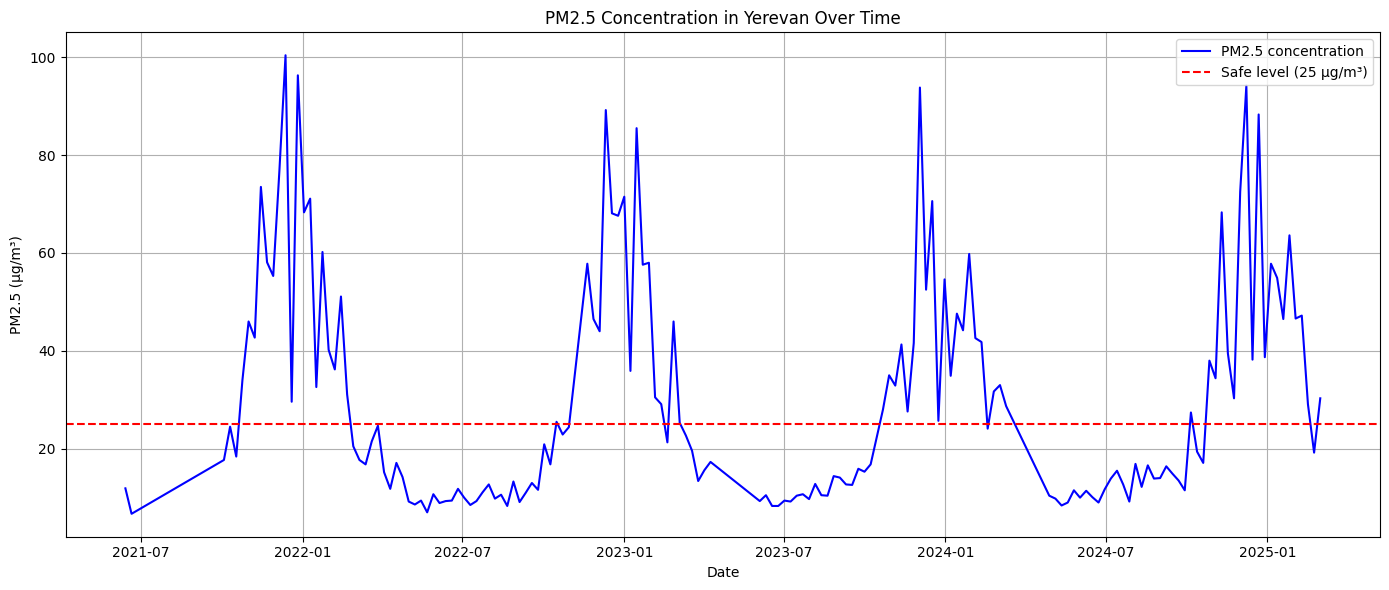

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(df_week['time_stamp'], df_week['pm2.5_alt'], 
         color='blue', label='PM2.5 concentration')
plt.axhline(y=safe_pm25, color='red', linestyle='--', label='Safe level (25 µg/m³)')
plt.title('PM2.5 Concentration in Yerevan Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


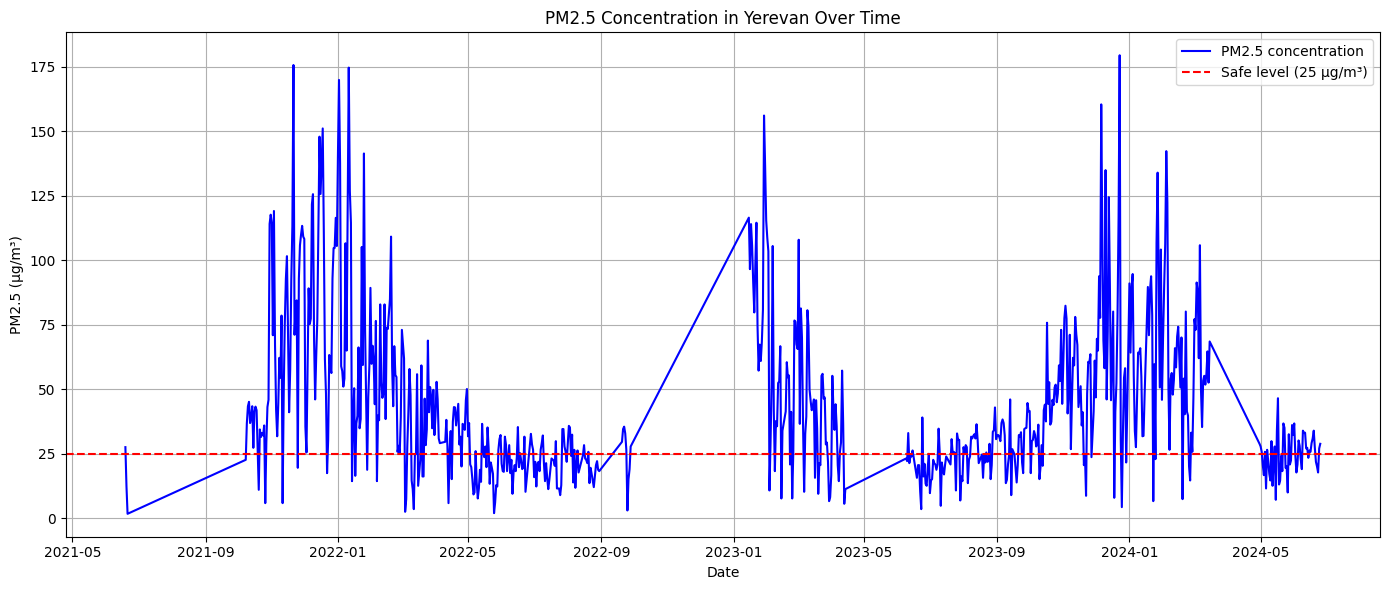

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['pm2.5_avg'], 
         color='blue', label='PM2.5 concentration')
plt.axhline(y=safe_pm25, color='red', linestyle='--', label='Safe level (25 µg/m³)')
plt.title('PM2.5 Concentration in Yerevan Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Deterministic simulation

In [11]:
mean_mortality_list_deterministic = []
ci_lower_list_deterministic = []
ci_upper_list_deterministic = []

error_fraction = 0.05

for pm in df['pm2.5_avg']:
    expected_mortality = baseline_mortality * (1 + risk_increase_per_10ug * ((pm - safe_pm25) / 10))
    expected_mortality = np.clip(expected_mortality, 0, None)
    
    sigma = error_fraction * expected_mortality  
    ci_lower = expected_mortality - 1.96 * sigma
    ci_upper = expected_mortality + 1.96 * sigma
    
    mean_mortality_list_deterministic.append(expected_mortality)
    ci_lower_list_deterministic.append(ci_lower)
    ci_upper_list_deterministic.append(ci_upper)

mortality_deterministic = pd.DataFrame({
    'pm2.5': df['pm2.5_avg'],
    'mean_mortality': mean_mortality_list_deterministic,
    'ci_lower': ci_lower_list_deterministic,
    'ci_upper': ci_upper_list_deterministic
})

mortality_deterministic['mean_mortality'] = mortality_deterministic['mean_mortality'].round(0).astype(int)
mortality_deterministic['ci_lower'] = mortality_deterministic['ci_lower'].round(0).astype(int)
mortality_deterministic['ci_upper'] = mortality_deterministic['ci_upper'].round(0).astype(int)
df['mean_mortality'] = mean_mortality_list_deterministic

mortality_deterministic.head()

,pm2.5,mean_mortality,ci_lower,ci_upper
0,27.641667,26,24,29
1,12.400000,25,22,27
2,1.808333,24,21,26
3,22.733333,26,23,28
4,36.825107,27,25,30


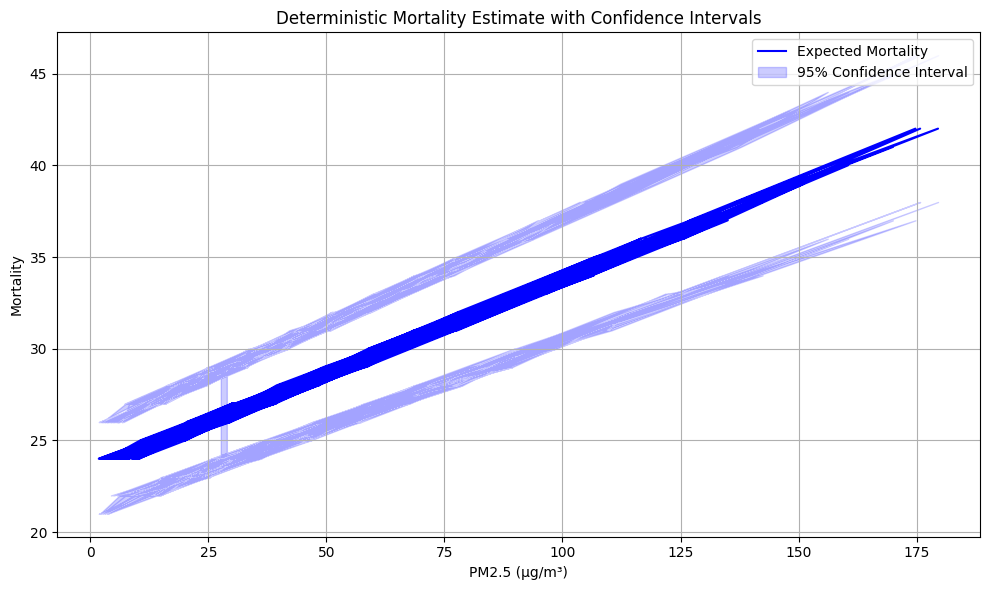

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(mortality_deterministic['pm2.5'], mortality_deterministic['mean_mortality'], label='Expected Mortality', color='blue')
plt.fill_between(
    mortality_deterministic['pm2.5'],
    mortality_deterministic['ci_lower'],
    mortality_deterministic['ci_upper'],
    color='blue',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.xlabel('PM2.5 (μg/m³)')
plt.ylabel('Mortality')
plt.title('Deterministic Mortality Estimate with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Monte Carlo: underlying lognormal distribution

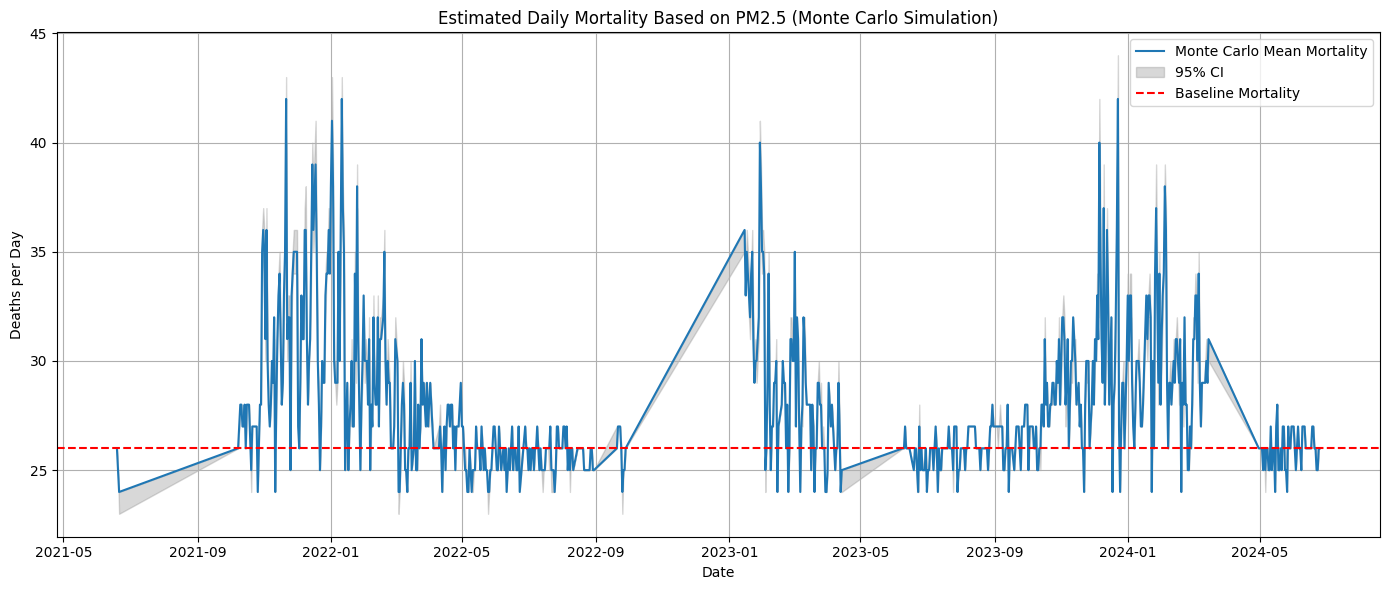

In [13]:
rr_mean = 1.04                  
rr_log_mean = np.log(rr_mean)   
rr_log_std = 0.05 * rr_log_mean 

mc_mean = []
mc_lower = []
mc_upper = []

for pm25 in df['pm2.5_avg']:
    rr_samples = np.random.lognormal(mean=rr_log_mean, sigma=rr_log_std, size=n_simulations)
    excess_risk = (rr_samples - 1) * ((pm25 - safe_pm25) / 10)

    mortality_samples = baseline_mortality * (1 + excess_risk)
    mortality_samples = np.clip(mortality_samples, 0, None)  

    mc_mean.append(np.mean(mortality_samples))
    mc_lower.append(np.percentile(mortality_samples, 2.5))
    mc_upper.append(np.percentile(mortality_samples, 97.5))

mortality_lognormal = pd.DataFrame({
    'pm2.5': df['pm2.5_avg'],
    'mean_mortality':mc_mean,
    'ci_lower': mc_lower,
    'ci_upper': mc_upper
})

mortality_lognormal['mean_mortality'] = mortality_lognormal['mean_mortality'].round(0).astype(int)
mortality_lognormal['ci_lower'] = mortality_lognormal['ci_lower'].round(0).astype(int)
mortality_lognormal['ci_upper'] = mortality_lognormal['ci_upper'].round(0).astype(int)

mortality_lognormal.head()

plt.figure(figsize=(14, 6))
plt.plot(df["date"], mortality_lognormal["mean_mortality"], label="Monte Carlo Mean Mortality")
plt.fill_between(df["date"], mortality_lognormal["ci_lower"], mortality_lognormal["ci_upper"], color='gray', alpha=0.3, label="95% CI")
plt.axhline(y=baseline_mortality, color='red', linestyle='--', label="Baseline Mortality")
plt.title("Estimated Daily Mortality Based on PM2.5 (Monte Carlo Simulation)")
plt.xlabel("Date")
plt.ylabel("Deaths per Day")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


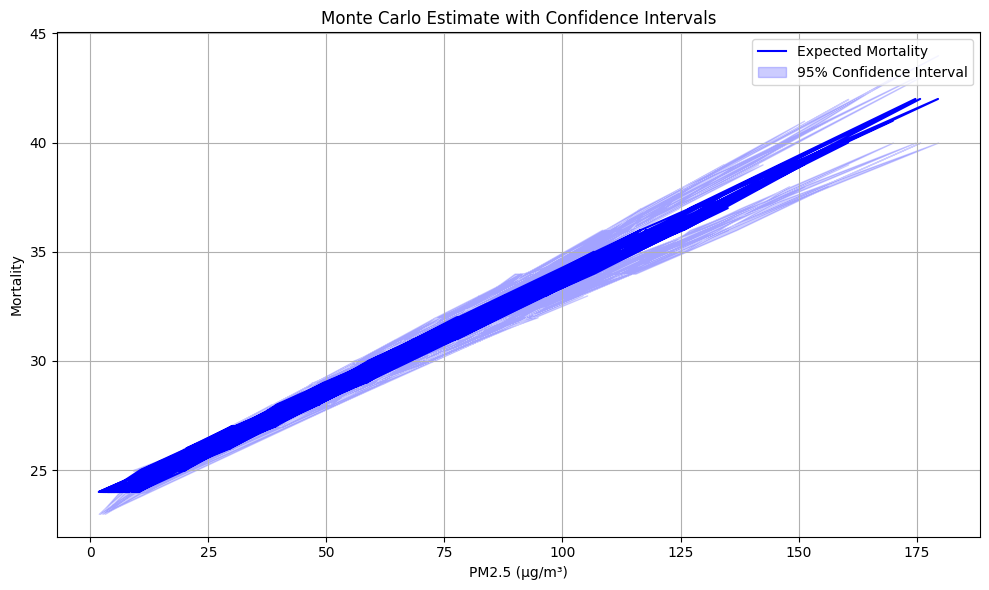

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(mortality_lognormal['pm2.5'], mortality_lognormal['mean_mortality'], label='Expected Mortality', color='blue')
plt.fill_between(
    mortality_lognormal['pm2.5'],
    mortality_lognormal['ci_lower'],
    mortality_lognormal['ci_upper'],
    color='blue',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.xlabel('PM2.5 (μg/m³)')
plt.ylabel('Mortality')
plt.title('Monte Carlo Estimate with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Hypothetical Scenarios

In [15]:
percent_changes = [-0.1, 0.1, 0.2, -0.2]  # 10% decrease, 10% increase, etc.
original_pm25 = df['pm2.5_avg']  
modified_risks = [risk_increase_per_10ug * (1 + change) for change in percent_changes]

all_mean_mortality = []
all_ci_lower = []
all_ci_upper = []

for modified_risk in modified_risks:
    mean_list = []
    lower_list = []
    upper_list = []

    for pm in original_pm25:
        expected_mortality = baseline_mortality * (1 + modified_risk * ((pm - safe_pm25) / 10))
        simulated_mortality = np.random.normal(loc=expected_mortality, scale=pm25_uncertainty, size=n_simulations)
        simulated_mortality = np.clip(simulated_mortality, 0, None)  # No negative values

        mean_list.append(np.mean(simulated_mortality))
        lower_list.append(np.percentile(simulated_mortality, 2.5))
        upper_list.append(np.percentile(simulated_mortality, 97.5))

    all_mean_mortality.append(mean_list)
    all_ci_lower.append(lower_list)
    all_ci_upper.append(upper_list)

flat_risk_scenarios = []
flat_mean_mortality = []
flat_ci_lower = []
flat_ci_upper = []

for i, change in enumerate(percent_changes):
    for mean, ci_lower, ci_upper in zip(all_mean_mortality[i], all_ci_lower[i], all_ci_upper[i]):
        flat_risk_scenarios.append(f"{int(change * 100)}%")
        flat_mean_mortality.append(int(round(mean)))  
        flat_ci_lower.append(ci_lower)
        flat_ci_upper.append(ci_upper)

mortality_results_risk_scenarios = pd.DataFrame({
    'risk_change': flat_risk_scenarios,
    'mean_mortality': flat_mean_mortality,
    'ci_lower': np.round(flat_ci_lower).astype(int),
    'ci_upper': np.round(flat_ci_upper).astype(int)
})

mortality_results_risk_scenarios.head()


,risk_change,mean_mortality,ci_lower,ci_upper
0,-10%,26,22,30
1,-10%,25,21,29
2,-10%,24,20,28
3,-10%,26,22,30
4,-10%,27,23,31


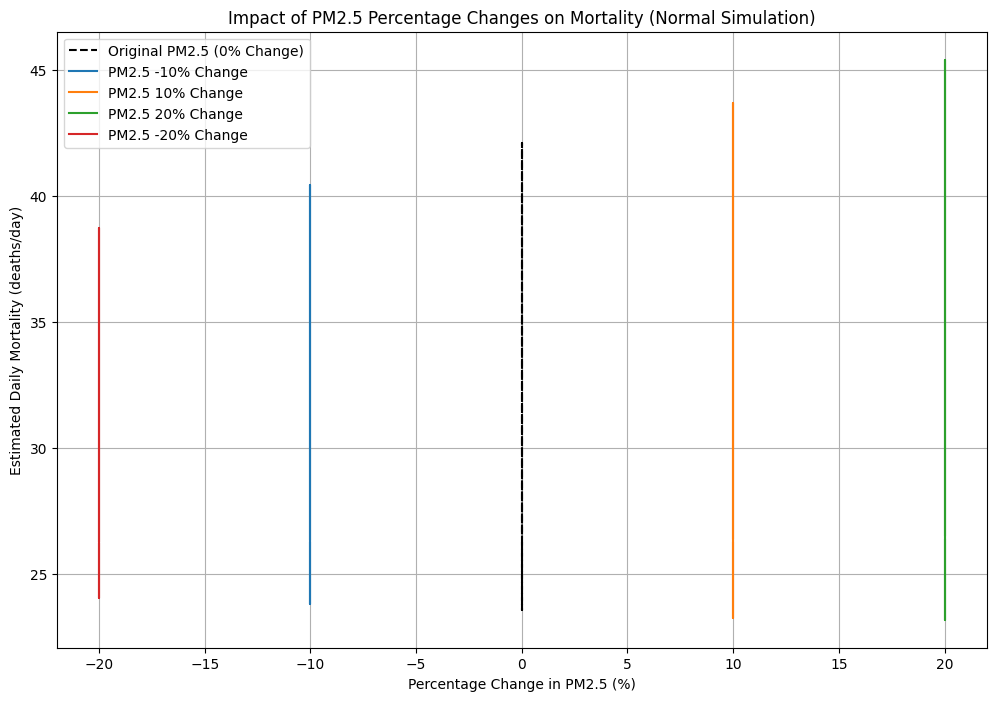

In [16]:
plt.figure(figsize=(12, 8))

original_mean_mortality = []
for pm in original_pm25:
    expected_mortality = baseline_mortality * (1 + risk_increase_per_10ug * ((pm - safe_pm25) / 10))
    simulated_mortality = np.random.normal(loc=expected_mortality, scale=pm25_uncertainty, size=n_simulations)
    simulated_mortality = np.clip(simulated_mortality, 0, None)
    original_mean_mortality.append(np.mean(simulated_mortality))

plt.plot([0] * len(original_pm25), original_mean_mortality, label='Original PM2.5 (0% Change)', color='black', linestyle='--')

for i, change in enumerate(percent_changes):
    modified_mean_mortality = all_mean_mortality[i]
    plt.plot([change * 100] * len(modified_mean_mortality), modified_mean_mortality, label=f'PM2.5 {round(change * 100)}% Change')

plt.title('Impact of PM2.5 Percentage Changes on Mortality (Normal Simulation)')
plt.xlabel('Percentage Change in PM2.5 (%)')
plt.ylabel('Estimated Daily Mortality (deaths/day)')
plt.legend()
plt.grid(True)
plt.show()


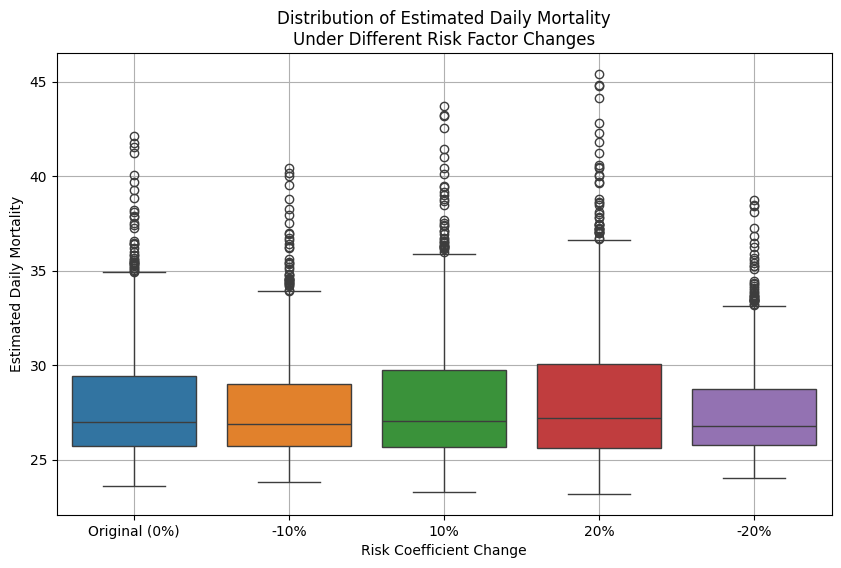

In [17]:
boxplot_data = []
labels = []

for i, change in enumerate(percent_changes):
    boxplot_data.append(all_mean_mortality[i])
    labels.append(f'{int(change * 100)}%')

boxplot_data.insert(0, original_mean_mortality)
labels.insert(0, 'Original (0%)')

plt.figure(figsize=(10, 6))
sns.boxplot(data=boxplot_data)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.title('Distribution of Estimated Daily Mortality\nUnder Different Risk Factor Changes')
plt.xlabel('Risk Coefficient Change')
plt.ylabel('Estimated Daily Mortality')
plt.grid(True)
plt.show()
